In [1]:
%matplotlib inline

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import requests
import re

# Working with Text

In [3]:
twitter_data = pd.read_csv("twitter_sentiment/twitter_training.csv", header = None)

In [4]:
twitter_data

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [5]:
twitter_data.columns = ["twitter_id", "entity", "sentiment", "content"]

In [6]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   twitter_id  74682 non-null  int64 
 1   entity      74682 non-null  object
 2   sentiment   74682 non-null  object
 3   content     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
twitter_data.twitter_id.nunique()

12447

In [8]:
twitter_data.drop_duplicates()

,twitter_id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [9]:
with open("twitter_sentiment/twitter_training.csv", "r", encoding='utf-8') as file:
    print(file.read()[:2000])

2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"
2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,"
2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,"
2402,Borderlands,Positive,So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg
2402,Borderlands,Positive,"So I spent a couple of hours doing something for fun... If you don't know that I'm a huge @ Borderlands fan and Maya is one of my favorite characters, I decided to make a 

In [10]:
with open("alice.txt", "r", encoding='utf-8') as file:
    print(file.read()[:2000])




Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Alice's Adventures in Wonderland

Author: Lewis Carroll

Release Date: June 25, 2008 [EBook #11]
Last Updated: October 6, 2016

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ***



Produced by Arthur DiBianca and David Widger

















ALICE’S ADVENTURES
IN WONDERLAND


By Lewis Carroll



THE MILLENNIUM FULCRUM EDITION 3.0





Contents
CHAPTER I. 	Down the Rabbit-Hole
CHAPTER II. 	The Pool of Tears
CHAPTER III. 	A Caucus-Race and a Long Tale
CHAPTER IV. 	The Rabbit Sends in a Little Bill
CHAPTER V. 	Advice from a Caterpillar
CHAPTER VI. 	Pig and Pepper
CHAPTER VII. 	A Mad 

In [11]:
twitter_data.content

0        im getting on borderlands and i will murder yo...
1        I am coming to the borders and I will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    Just realized that the Windows partition of my...
74678    Just realized that my Mac window partition is ...
74679    Just realized the windows partition of my Mac ...
74680    Just realized between the windows partition of...
74681    Just like the windows partition of my Mac is l...
Name: content, Length: 74682, dtype: object

In [12]:
twitter_data.content.str.len().sort_values(ascending = False)

70940    957.0
28994    727.0
3098     692.0
18128    692.0
36308    692.0
         ...  
73972      NaN
73973      NaN
74421      NaN
74422      NaN
74423      NaN
Name: content, Length: 74682, dtype: float64

In [13]:
twitter_data.loc[70940, "content"] # text generator was used here

'The event dedicated to Victory Day in the Great Patriotic War was held as part of the celebration of the 70th anniversary of Victory in the Great Patriotic War of 1941-1945, which was attended by veterans of the Great Patriotic War, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home front workers, home'

In [14]:
twitter_data = twitter_data.dropna(subset = ["content"])

In [15]:
twitter_data.content.str.len().sort_values(ascending = False)

70940    957
28994    727
3098     692
18128    692
36308    692
        ... 
39666      1
51983      1
55494      1
29339      1
69402      1
Name: content, Length: 73996, dtype: int64

In [16]:
twitter_data[twitter_data.content.str.len() <= 2]

,twitter_id,entity,sentiment,content
203,2434,Borderlands,Negative,I
389,2465,Borderlands,Irrelevant,is
485,2481,Borderlands,Positive,of
515,2488,Borderlands,Positive,It
521,2489,Borderlands,Neutral,on
...,...,...,...,...
74177,9109,Nvidia,Negative,do
74207,9115,Nvidia,Neutral,me
74375,9145,Nvidia,Positive,a
74411,9151,Nvidia,Positive,to


In [17]:
twitter_data.content.str.len().mean()

108.78365046759285

In [18]:
twitter_data.content.str.len().median()

91.0

In [19]:
for sentiment, group_data in twitter_data.groupby("sentiment"):
    print(sentiment, group_data, group_data.shape)
    break

Irrelevant        twitter_id       entity   sentiment  \
102          2418  Borderlands  Irrelevant   
103          2418  Borderlands  Irrelevant   
104          2418  Borderlands  Irrelevant   
105          2418  Borderlands  Irrelevant   
106          2418  Borderlands  Irrelevant   
...           ...          ...         ...   
74035        9085       Nvidia  Irrelevant   
74036        9085       Nvidia  Irrelevant   
74037        9085       Nvidia  Irrelevant   
74038        9085       Nvidia  Irrelevant   
74039        9085       Nvidia  Irrelevant   

                                                 content  
102    Appreciate the (sonic) concepts / praxis Valen...  
103    Appreciate the (sound) concepts / practices th...  
104    Evaluate the (sound) concepts / concepts of Va...  
105    Appreciate the (sonic) concepts / praxis Valen...  
106    Appreciate by the ( sonic ) electronic concept...  
...                                                  ...  
74035  This is all base

In [20]:
for sentiment, group_data in twitter_data.groupby("sentiment"):
    print(sentiment, group_data.content.str.len().mean())

Irrelevant 110.92947572815534
Negative 111.28571428571429
Neutral 118.8346034901701
Positive 95.92616799806342


In [21]:
for sentiment, group_data in twitter_data.groupby("sentiment"):
    print(sentiment, group_data.content.str.len().median())

Irrelevant 93.0
Negative 91.0
Neutral 105.0
Positive 74.0


In [22]:
twitter_data.loc[0].content

'im getting on borderlands and i will murder you all ,'

In [23]:
Counter(twitter_data.loc[0].content)

Counter({' ': 10,
         'l': 5,
         'i': 4,
         'n': 4,
         'r': 4,
         'd': 4,
         'e': 3,
         'o': 3,
         'a': 3,
         'm': 2,
         'g': 2,
         't': 2,
         'u': 2,
         'b': 1,
         's': 1,
         'w': 1,
         'y': 1,
         ',': 1})

In [24]:
Counter(twitter_data.content) # count all emelemnts

Counter({' ': 172,
         'It is not the first time that the EU Commission has taken such a step.': 172,
         'At the same time, despite the fact that there are currently some 100 million people living below the poverty line, most of them do not have access to health services and do not have access to health care, while most of them do not have access to health care.': 172,
         '<unk>': 133,
         'to': 74,
         'I': 72,
         'the': 68,
         'you': 63,
         'of': 57,
         'a': 53,
         'Wow': 48,
         'is': 46,
         'in': 44,
         'it': 31,
         'that': 30,
         'and': 29,
         'was': 26,
         'The': 23,
         'Wow.': 23,
         'not': 22,
         'Wtf': 20,
         'be': 20,
         'Check out my video!  ': 20,
         'Take a look at my video!': 20,
         'Watch my video!': 20,
         '<unk>.': 19,
         'are': 19,
         'on': 18,
         '.': 18,
         'You': 17,
         'can': 16,
         "C

In [29]:
all_texts = "".join(twitter_data.content.ravel())

In [27]:
Counter(" ".join(twitter_data.content.ravel()))

Counter({' ': 1435996,
         'e': 645445,
         't': 495077,
         'o': 473359,
         'a': 459770,
         'n': 382395,
         'i': 378497,
         's': 352664,
         'r': 307248,
         'l': 250954,
         'h': 245582,
         'd': 200985,
         '.': 181075,
         'u': 167637,
         'm': 166695,
         'c': 165828,
         'y': 142591,
         'g': 141430,
         'p': 121339,
         'f': 112150,
         'w': 109137,
         'b': 92905,
         'k': 70703,
         'v': 66659,
         'I': 56573,
         'T': 41011,
         'A': 40142,
         'S': 36064,
         '/': 34279,
         ',': 32037,
         '!': 29426,
         '@': 28914,
         'E': 27906,
         'R': 27027,
         'O': 26915,
         'C': 24388,
         'G': 24136,
         'N': 23321,
         '2': 22155,
         'M': 21996,
         'D': 21916,
         "'": 21852,
         'B': 21473,
         '0': 21412,
         'P': 21144,
         'F': 20629,
         'L'

In [32]:
frequencies = Counter(all_texts.lower()).most_common(20)

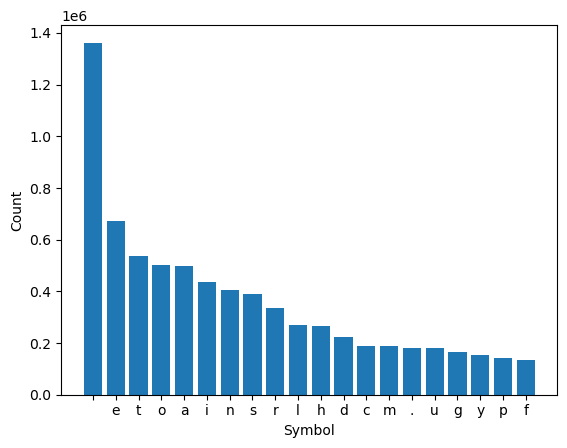

In [34]:
plt.bar([symbol for symbol, frequency in frequencies], [frequency for symbol, frequency in frequencies])
plt.xlabel("Symbol")
plt.ylabel("Count")

plt.show()

In [35]:
words = all_texts.split(" ")

In [39]:
np.array([word == "" for word in words]).any()

True

In [40]:
Counter(words)

Counter({'the': 37674,
         'to': 27473,
         'and': 24330,
         'a': 21657,
         'I': 20002,
         'of': 18426,
         'is': 16295,
         'for': 14527,
         '/': 14434,
         'in': 13791,
         'on': 10891,
         'this': 10116,
         'my': 9890,
         '.': 9492,
         'you': 9201,
         '': 9160,
         'it': 9153,
         'that': 8845,
         '@': 8353,
         'with': 8169,
         'have': 6213,
         'so': 5902,
         'be': 5677,
         'just': 5607,
         'but': 5488,
         'are': 5483,
         'game': 5403,
         'not': 5326,
         'me': 5133,
         'was': 5085,
         'at': 4639,
         '-': 4619,
         'all': 4491,
         'like': 4275,
         'from': 3995,
         'your': 3749,
         'out': 3666,
         'get': 3498,
         'has': 3491,
         'as': 3345,
         'about': 3246,
         'i': 3196,
         '&': 3039,
         'an': 3018,
         'they': 2971,
         'will': 2

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diton\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [47]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [49]:
twitter_data.content.apply(lambda x: x.split(" "))

0        [im, getting, on, borderlands, and, i, will, m...
1        [I, am, coming, to, the, borders, and, I, will...
2        [im, getting, on, borderlands, and, i, will, k...
3        [im, coming, on, borderlands, and, i, will, mu...
4        [im, getting, on, borderlands, 2, and, i, will...
                               ...                        
74677    [Just, realized, that, the, Windows, partition...
74678    [Just, realized, that, my, Mac, window, partit...
74679    [Just, realized, the, windows, partition, of, ...
74680    [Just, realized, between, the, windows, partit...
74681    [Just, like, the, windows, partition, of, my, ...
Name: content, Length: 73996, dtype: object

In [52]:
twitter_data.content.str.split("\s+") # tokenization

0        [im, getting, on, borderlands, and, i, will, m...
1        [I, am, coming, to, the, borders, and, I, will...
2        [im, getting, on, borderlands, and, i, will, k...
3        [im, coming, on, borderlands, and, i, will, mu...
4        [im, getting, on, borderlands, 2, and, i, will...
                               ...                        
74677    [Just, realized, that, the, Windows, partition...
74678    [Just, realized, that, my, Mac, window, partit...
74679    [Just, realized, the, windows, partition, of, ...
74680    [Just, realized, between, the, windows, partit...
74681    [Just, like, the, windows, partition, of, my, ...
Name: content, Length: 73996, dtype: object

<h3><span style="color: green">"token" is the smallest meaning entity e.g. word. token == word or charcter/symbol</span></h3>

![tokens explanation](tokens.png)

In [53]:
twitter_data["words"] = twitter_data.content.str.split("\s+")

C:\Users\diton\AppData\Local\Temp\ipykernel_30932\3062704304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data["words"] = twitter_data.content.str.split("\s+")


In [56]:
twitter_data

,twitter_id,entity,sentiment,content,words
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,"[im, getting, on, borderlands, and, i, will, m..."
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[I, am, coming, to, the, borders, and, I, will..."
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, getting, on, borderlands, and, i, will, k..."
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[im, coming, on, borderlands, and, i, will, mu..."
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[im, getting, on, borderlands, 2, and, i, will..."
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,"[Just, realized, that, the, Windows, partition..."
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,"[Just, realized, that, my, Mac, window, partit..."
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,"[Just, realized, the, windows, partition, of, ..."
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,"[Just, realized, between, the, windows, partit..."


In [58]:
twitter_data.words.apply(lambda x: len(x)).sort_values(ascending = False)

1826     198
32186    198
43712    198
10454    198
68624    194
        ... 
16535      1
35418      1
61169      1
69474      1
59351      1
Name: words, Length: 73996, dtype: int64

In [62]:
twitter_data[twitter_data.content.str.contains("happy")]

,twitter_id,entity,sentiment,content,words
233,2439,Borderlands,Positive,I got to play Jackson 2 with his entire polycu...,"[I, got, to, play, Jackson, 2, with, his, enti..."
385,2465,Borderlands,Irrelevant,Pretty happy with it! I made these sub-badges ...,"[Pretty, happy, with, it!, I, made, these, sub..."
394,2466,Borderlands,Positive,Now I am happy here... With Samsung that is fu...,"[Now, I, am, happy, here..., With, Samsung, th..."
570,2499,Borderlands,Neutral,i kno borderlands handled zer0 being nonbinary...,"[i, kno, borderlands, handled, zer0, being, no..."
571,2499,Borderlands,Neutral,i kno borderlands handling zer0 being nonbinar...,"[i, kno, borderlands, handling, zer0, being, n..."
...,...,...,...,...,...
73192,8938,Nvidia,Negative,So that some GeForce Networks RTX 3080 pics le...,"[So, that, some, GeForce, Networks, RTX, 3080,..."
73193,8938,Nvidia,Negative,"So first GeForce RTX 3080 pics leaked, that so...","[So, first, GeForce, RTX, 3080, pics, leaked,,..."
73405,8974,Nvidia,Positive,"Fucking W, I was happy when the new graphics c...","[Fucking, W,, I, was, happy, when, the, new, g..."
74109,9097,Nvidia,Neutral,Nvidia RTX 3080 cards are selling @ thousands ...,"[Nvidia, RTX, 3080, cards, are, selling, @, th..."


In [64]:
twitter_data[twitter_data.content.str.contains("happy", case = False)]

,twitter_id,entity,sentiment,content,words
233,2439,Borderlands,Positive,I got to play Jackson 2 with his entire polycu...,"[I, got, to, play, Jackson, 2, with, his, enti..."
384,2465,Borderlands,Irrelevant,Pretty Happy with this! I made these sub badge...,"[Pretty, Happy, with, this!, I, made, these, s..."
385,2465,Borderlands,Irrelevant,Pretty happy with it! I made these sub-badges ...,"[Pretty, happy, with, it!, I, made, these, sub..."
386,2465,Borderlands,Irrelevant,Pretty Happy with this! I made these subbids f...,"[Pretty, Happy, with, this!, I, made, these, s..."
387,2465,Borderlands,Irrelevant,Pretty Happy with this! I made these sub badge...,"[Pretty, Happy, with, this!, I, made, these, s..."
...,...,...,...,...,...
73192,8938,Nvidia,Negative,So that some GeForce Networks RTX 3080 pics le...,"[So, that, some, GeForce, Networks, RTX, 3080,..."
73193,8938,Nvidia,Negative,"So first GeForce RTX 3080 pics leaked, that so...","[So, first, GeForce, RTX, 3080, pics, leaked,,..."
73405,8974,Nvidia,Positive,"Fucking W, I was happy when the new graphics c...","[Fucking, W,, I, was, happy, when, the, new, g..."
74109,9097,Nvidia,Neutral,Nvidia RTX 3080 cards are selling @ thousands ...,"[Nvidia, RTX, 3080, cards, are, selling, @, th..."


In [67]:
twitter_data[twitter_data.content.str.contains("happy", case = False)].sentiment.value_counts()

sentiment
Positive      531
Neutral       281
Irrelevant    252
Negative      121
Name: count, dtype: int64

In [73]:
twitter_data[
    (twitter_data.content.str.contains("happy", case = False)) &
    (twitter_data.sentiment == "Negative")
].content.values

array(['Saw ran an ad for the new borderlands dlc s stuff and i just half got sad happy again knowing fully well bl3 was likely so horribly mediocre I might already miss the BL2',
       'SO HAPPY ABOUT THIS . ', 'SO HAPPY FOR THAT.',
       'So HAPPY ABOUT THIS.', 'SO HAPPY ABOUT THIS RELEASE',
       'SO I HAPPY WHO ABOUT THIS.', 'Y HAPPY ABOUT THIS.',
       '@Hunduks we will never be as happy as we were during the overwatch beta . ',
       '@ Hunduks we will never be as happy as we were during the Overwatch beta.',
       '@ Hunduks we will never be as happy as we were during the overwatch beta.',
       '@Hunduks Q will never be as happy as we were during the overwatch beta.',
       'For @Hunduks we will never be as happy inside as we were during the overwatch campaign beta.',
       '@Hunduks we will probably be as happy as we feel after the overwatch beta.',
       'I don’t want a ps5 or xbox x/s , just get me a truly and I’ll be as happy',
       'I do not want ps5 or xbox x 

In [74]:
twitter_data.words.loc[42]

['Check', 'out', 'this', 'epic', 'streamer!.', '']

In [83]:
def clean_characters(words, characters = [".", "!", "?"], replacement = ""):
    words_no_empty = [word for word in words if word != ""]
    words_cleaned = words_no_empty.copy()
    for character in characters:
        words_cleaned = [word.replace(character, replacement) for word in words_cleaned]
    return words_cleaned

In [76]:
# [word.replace(".", "").replace("!", "").replace("?", "") for word in twitter_data.words.loc[42] if word != ""]

['Check', 'out', 'this', 'epic', 'streamer']

In [79]:
twitter_data.words.loc[43]

['Check', 'out', 'this', 'epic', 'streamer!.']

In [84]:
twitter_data.words.loc[43] = clean_characters(twitter_data.words.loc[43])
twitter_data.words.loc[43]

C:\Users\diton\AppData\Local\Temp\ipykernel_30932\1538753889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data.words.loc[43] = clean_characters(twitter_data.words.loc[43])


['Check', 'out', 'this', 'epic', 'streamer']

In [85]:
twitter_data.words.apply(clean_characters)

0        [im, getting, on, borderlands, and, i, will, m...
1        [I, am, coming, to, the, borders, and, I, will...
2        [im, getting, on, borderlands, and, i, will, k...
3        [im, coming, on, borderlands, and, i, will, mu...
4        [im, getting, on, borderlands, 2, and, i, will...
                               ...                        
74677    [Just, realized, that, the, Windows, partition...
74678    [Just, realized, that, my, Mac, window, partit...
74679    [Just, realized, the, windows, partition, of, ...
74680    [Just, realized, between, the, windows, partit...
74681    [Just, like, the, windows, partition, of, my, ...
Name: words, Length: 73996, dtype: object

In [88]:
clean_characters("Jonny is selling a lot of things".split(" "), characters = ["James", "Jonny", "Peter"], replacement = "[NAME]")

['[NAME]', 'is', 'selling', 'a', 'lot', 'of', 'things']

In [89]:
" ".join(clean_characters("Jonny is selling a lot of things".split(" "), characters = ["James", "Jonny", "Peter"], replacement = "[NAME]"))

'[NAME] is selling a lot of things'

@username -> [MENTION] # special tokens

[BOS] begining of sentence, [EOS] end of sentence

In [93]:
twitter_data.words.sample(20).apply(lambda words: [word.lower() for word in words])

49442    [great, deal!, fifa, 2007., rover.ebay.com, /,...
71561    [i, call, this, one, the, oblivious, hunter, (...
29220    [bruh, my, dreams, arent, sad, anymore,, i, ha...
47571    [target, gives, pay, break, over, $2, per, hou...
13016    [youtu.be, /, r-atru18xxy, go, spam, glidey, s...
13777                      [we, were, robbed..., @, nba2k]
47188    [and, this, is, why, you, load, things, yourse...
26733    [i, was, told, through, xbots, that, this, was...
21615    [amazing, phoenix, fan-art...., join, @valoran...
12391    [that's, what, the, world, needs, right, now,,...
21523    [i, don't, expect, anything, so, i, won't, be,...
29967    [look, at, me<unk>, i'm, a, super, dooper, coo...
7122     [i, can't, get, overwatch, out, of, my, head.,...
25444    [do, you, not, want, me, to, succeed?, i, know...
7898     [well,, i, think, this, skin, is, absolutely, ...
54300    [i’m, getting, nostalgic, bro, ., can’t, wait,...
26039                                               [dam

In [96]:
words_lower = twitter_data.words.sample(20).apply(lambda words: [word.lower() for word in words if not word in stopwords.words("english")])

In [97]:
words_lower

2210     [scumbag, ceo, randy, pitchford, screws, gearb...
55652                         [when, play, hard,, matter!]
17698    [ah, well,, seems, mistake..., guess, i'll, wa...
31578    [i, edited, ago,, i, really, get, back, editin...
21910    [idk, people, play, valorant, game, instead, c...
5754     [amazon, shuts, new, york, delivery, station, ...
73039    [amazing, offer, you!.., acer, nitro, 5, an515...
48074         [my, flat, smells, fucking, homemade, depot]
58206          [spawn, peeking, doc, @rainbow6game, life.]
5605     [an, amazing, reading, book, child!, select, t...
52026    [@shirleyscurry, i, highly, recommend, red, de...
28282                                          [the, lame]
24706    [thank, you, @youtubeindia, @ytcreatorsindia, ...
54170                                                [wtf]
2035     [@, borderlands, @, gearboxofficial, @, duvalm...
31946                  [avril, lavigne, league, gentlemen]
18410        [the, ladies, men, give, attention, craves!

In [98]:
words_lower.apply(len)

2210     18
55652     4
17698    21
31578    16
21910    15
5754     11
73039    45
48074     6
58206     5
5605     12
52026    20
28282     2
24706     6
54170     1
2035     27
31946     4
18410     6
2551     15
32769    30
72903    25
Name: words, dtype: int64

In [105]:
words_lower.loc[31578]

['i',
 'edited',
 'ago,',
 'i',
 'really',
 'get',
 'back',
 'editing,',
 'it’s',
 'pretty',
 'fun',
 'motivations',
 'hit!',
 '.',
 '.',
 '']

In [103]:
stemmer = PorterStemmer()

In [106]:
stemmer.stem(words_lower.loc[31578][11])

'motiv'

In [109]:
words_in_line_31578 = words_lower.loc[31578]
[stemmer.stem(word) for word in words_in_line_31578]

['i',
 'edit',
 'ago,',
 'i',
 'realli',
 'get',
 'back',
 'editing,',
 'it’',
 'pretti',
 'fun',
 'motiv',
 'hit!',
 '.',
 '.',
 '']

In [110]:
words_lower.apply(lambda words: [stemmer.stem(word) for word in words])

2210     [scumbag, ceo, randi, pitchford, screw, gearbo...
55652                         [when, play, hard,, matter!]
17698    [ah, well,, seem, mistake..., guess, i'll, wai...
31578    [i, edit, ago,, i, realli, get, back, editing,...
21910    [idk, peopl, play, valor, game, instead, csgo,...
5754     [amazon, shut, new, york, deliveri, station, a...
73039    [amaz, offer, you!.., acer, nitro, 5, an515-54...
48074              [my, flat, smell, fuck, homemad, depot]
58206              [spawn, peek, doc, @rainbow6gam, life.]
5605     [an, amaz, read, book, child!, select, the, wi...
52026    [@shirleyscurri, i, highli, recommend, red, de...
28282                                          [the, lame]
24706    [thank, you, @youtubeindia, @ytcreatorsindia, ...
54170                                                [wtf]
2035     [@, borderland, @, gearboxoffici, @, duvalmag,...
31946                    [avril, lavign, leagu, gentlemen]
18410             [the, ladi, men, give, attent, craves!

In [111]:
words_final = words_lower.apply(lambda words: [stemmer.stem(word) for word in words])

In [115]:
Counter(words_final.loc[32769])

Counter({'-': 2,
         'epic': 2,
         'yup': 1,
         'i': 1,
         'saw': 1,
         'same': 1,
         'thing': 1,
         'day': 1,
         'ago': 1,
         'thread...': 1,
         '"the': 1,
         'current': 1,
         'predica': 1,
         'aros': 1,
         'making,”': 1,
         'roger': 1,
         'wrote,': 1,
         '“strateg': 1,
         'began': 1,
         'breach': 1,
         'agreement': 1,
         'apple”..': 1,
         'judg': 1,
         'protect': 1,
         'unreal<unk>': 1,
         '—': 1,
         'fortnit': 1,
         'theverge.com/2020/8/25/2140…': 1})

In [116]:
words_final.apply(Counter)

2210     {'scumbag': 1, 'ceo': 1, 'randi': 1, 'pitchfor...
55652     {'when': 1, 'play': 1, 'hard,': 1, 'matter!': 1}
17698    {'ah': 1, 'well,': 1, 'seem': 1, 'mistake...':...
31578    {'i': 2, 'edit': 1, 'ago,': 1, 'realli': 1, 'g...
21910    {'idk': 1, 'peopl': 1, 'play': 1, 'valor': 1, ...
5754     {'amazon': 1, 'shut': 1, 'new': 1, 'york': 1, ...
73039    {'amaz': 1, 'offer': 1, 'you!..': 1, 'acer': 1...
48074    {'my': 1, 'flat': 1, 'smell': 1, 'fuck': 1, 'h...
58206    {'spawn': 1, 'peek': 1, 'doc': 1, '@rainbow6ga...
5605     {'an': 1, 'amaz': 1, 'read': 1, 'book': 1, 'ch...
52026    {'@shirleyscurri': 1, 'i': 2, 'highli': 1, 're...
28282                                {'the': 1, 'lame': 1}
24706    {'thank': 1, 'you': 1, '@youtubeindia': 1, '@y...
54170                                           {'wtf': 1}
2035     {'@': 4, 'borderland': 1, 'gearboxoffici': 1, ...
31946    {'avril': 1, 'lavign': 1, 'leagu': 1, 'gentlem...
18410    {'the': 1, 'ladi': 1, 'men': 1, 'give': 1, 'at.

In [118]:
count_vectorizer = CountVectorizer()

In [119]:
count_vectorizer.fit(twitter_data.content)

CountVectorizer()

In [120]:
count_vectorizer.vocabulary_

{'im': 14087,
 'getting': 11958,
 'on': 19552,
 'borderlands': 4660,
 'and': 2629,
 'will': 29921,
 'murder': 18421,
 'you': 30664,
 'all': 2439,
 'am': 2527,
 'coming': 6463,
 'to': 27558,
 'the': 27084,
 'borders': 4665,
 'kill': 15676,
 'me': 17490,
 'into': 14619,
 'can': 5317,
 'so': 25235,
 'spent': 25547,
 'few': 10681,
 'hours': 13706,
 'making': 17120,
 'something': 25331,
 'for': 11135,
 'fun': 11516,
 'if': 14010,
 'don': 8782,
 'know': 15795,
 'huge': 13779,
 'fan': 10409,
 'maya': 17432,
 'is': 14763,
 'one': 19561,
 'of': 19420,
 'my': 18498,
 'favorite': 10506,
 'characters': 5768,
 'decided': 7891,
 'make': 17112,
 'myself': 18520,
 'wallpaper': 29444,
 'pc': 20340,
 'here': 13309,
 'original': 19764,
 'image': 14090,
 'versus': 29058,
 'creation': 7176,
 'made': 17026,
 'enjoy': 9694,
 'pic': 20643,
 'twitter': 28190,
 'com': 6428,
 'mlsi5wf9jg': 18021,
 'couple': 7037,
 'doing': 8756,
 'that': 27072,
 'picture': 20656,
 'compared': 6534,
 'have': 13052,
 'rhandlerr': 

In [121]:
count_vectorizer.transform(twitter_data.content)

<73996x31062 sparse matrix of type '<class 'numpy.int64'>'
	with 1213145 stored elements in Compressed Sparse Row format>

In [122]:
1213145 / (73996 * 31062) * 100 

0.052780688794608406

In [125]:
vectors = count_vectorizer.transform(twitter_data.content)

In [126]:
model = MultinomialNB()

In [127]:
model.fit(vectors, twitter_data.sentiment)

MultinomialNB()

In [128]:
model.feature_count_

array([[28., 61.,  0., ...,  0.,  0.,  0.],
       [18., 43.,  6., ...,  0.,  0.,  0.],
       [81., 85.,  0., ...,  2.,  2.,  0.],
       [19., 18.,  0., ...,  0.,  0.,  2.]])

In [129]:
count_vectorizer = CountVectorizer(ngram_range = (1, 3))

In [131]:
count_vectorizer.fit(twitter_data.content)

CountVectorizer(ngram_range=(1, 3))

In [132]:
count_vectorizer.transform(twitter_data.content)

<73996x910433 sparse matrix of type '<class 'numpy.int64'>'
	with 3626304 stored elements in Compressed Sparse Row format>

In [133]:
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5)

In [134]:
count_vectorizer.fit(twitter_data.content)

CountVectorizer(min_df=5, ngram_range=(1, 3))

In [135]:
count_vectorizer.transform(twitter_data.content)

<73996x132325 sparse matrix of type '<class 'numpy.int64'>'
	with 2384282 stored elements in Compressed Sparse Row format>

In [145]:
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.98)

In [146]:
count_vectorizer.fit(twitter_data.content)

CountVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 3))

In [147]:
count_vectorizer.transform(twitter_data.content)

<73996x132325 sparse matrix of type '<class 'numpy.int64'>'
	with 2384282 stored elements in Compressed Sparse Row format>

In [154]:
tfidf = TfidfVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.98)

In [155]:
tfidf.fit(twitter_data.content)

TfidfVectorizer(max_df=0.98, min_df=5, ngram_range=(1, 3))

In [156]:
tfidf.vocabulary_

{'im': 54939,
 'getting': 45318,
 'on': 80558,
 'borderlands': 18777,
 'and': 8158,
 'will': 126603,
 'murder': 72882,
 'you': 130332,
 'all': 6050,
 'im getting': 54958,
 'getting on': 45368,
 'on borderlands': 80663,
 'borderlands and': 18784,
 'and will': 10604,
 'you all': 130351,
 'on borderlands and': 80664,
 'am': 7098,
 'coming': 26424,
 'to': 114009,
 'the': 106611,
 'borders': 18950,
 'kill': 62519,
 'coming to': 26448,
 'to the': 115940,
 'will kill': 126754,
 'kill you': 62572,
 'coming to the': 26450,
 'will kill you': 126755,
 'coming on': 26437,
 'me': 69197,
 'you me': 130966,
 'me all': 69215,
 'into': 57266,
 'can': 21731,
 'getting into': 45355,
 'into borderlands': 57270,
 'and can': 8455,
 'so': 99383,
 'spent': 101226,
 'few': 38463,
 'hours': 53284,
 'making': 68189,
 'something': 100502,
 'for': 39944,
 'fun': 43019,
 'if': 54500,
 'don': 32632,
 'know': 62837,
 'huge': 53993,
 'fan': 37766,
 'maya': 69073,
 'is': 57547,
 'one': 81518,
 'of': 78459,
 'my': 73053

In [159]:
tfidf.transform(twitter_data.content)

<73996x132325 sparse matrix of type '<class 'numpy.float64'>'
	with 2384282 stored elements in Compressed Sparse Row format>

In [161]:
vectors_tfidf = tfidf.transform(twitter_data.content)

In [162]:
model.fit(vectors_tfidf, twitter_data.sentiment)

MultinomialNB()

# Quiz

In [167]:
text = requests.get("http://www.gutenberg.org/files/1342/1342-0.txt").text

In [180]:
tokens = re.split(r'\W+', text)

tokens = [token.lower() for token in tokens] # Convert all tokens to lower case

pride_count = tokens.count("pride")

In [181]:
pride_count

55

In [182]:
prejudice_count = tokens.count("prejudice")
prejudice_count

10

In [183]:
len(tokens)

132507

In [185]:
tokens_without_stopwords = [word for word in tokens if not word in stopwords.words("english")]

In [186]:
len(tokens_without_stopwords)

62488

In [188]:
count_vectorizer = CountVectorizer()

In [189]:
count_vectorizer.fit(tokens_without_stopwords)

CountVectorizer()

In [192]:
count_vectorizer.vocabulary_

{'start': 6009,
 'project': 4986,
 'gutenberg': 3083,
 'ebook': 2232,
 '1342': 6,
 'illustration': 3312,
 'george': 2944,
 'allen': 493,
 'publisher': 5051,
 '156': 13,
 'charing': 1191,
 'cross': 1691,
 'road': 5492,
 'london': 3907,
 'ruskin': 5528,
 'house': 3255,
 '_reading': 215,
 'janeâ': 3664,
 'letters': 3834,
 '_chap': 119,
 '34': 63,
 'pride': 4935,
 'prejudice': 4882,
 'jane': 3663,
 'austen': 775,
 'preface': 4875,
 'saintsbury': 5541,
 'illustrations': 3313,
 'hugh': 3266,
 'thomson': 6337,
 '1894': 24,
 'chiswick': 1229,
 'press': 4907,
 'charles': 1193,
 'whittingham': 6888,
 'co': 1296,
 'tooks': 6393,
 'court': 1652,
 'chancery': 1177,
 'lane': 3768,
 '_to': 244,
 'comyns': 1420,
 'carr': 1123,
 'acknowledgment': 348,
 'owe': 4533,
 'friendship': 2870,
 'advice': 426,
 'gratefully': 3022,
 'inscribed_': 3525,
 '_hugh': 162,
 'thomson_': 6338,
 '_walt': 254,
 'whitman': 6887,
 'somewhere': 5913,
 'fine': 2707,
 'distinction': 2109,
 'loving': 3944,
 'allowanceâ': 501,
 

In [194]:
Counter(tokens_without_stopwords)

Counter({'â': 3732,
         'mr': 807,
         'elizabeth': 605,
         'could': 530,
         'would': 482,
         'said': 406,
         'darcy': 383,
         'mrs': 353,
         'much': 335,
         'miss': 315,
         'must': 312,
         'bennet': 307,
         'one': 286,
         'jane': 273,
         'bingley': 262,
         'know': 241,
         'though': 238,
         'well': 230,
         'never': 228,
         'think': 222,
         'soon': 216,
         'good': 208,
         'might': 206,
         'may': 203,
         'time': 201,
         'little': 190,
         'lady': 190,
         'every': 185,
         'nothing': 185,
         'sister': 179,
         'without': 177,
         'make': 169,
         'wickham': 167,
         'collins': 167,
         'illustration': 163,
         'dear': 163,
         'shall': 162,
         'first': 160,
         'say': 160,
         'see': 153,
         'family': 152,
         'man': 151,
         'room': 151,
         'great':